# Hands on session: Dimensionality reduction with PCA
In this example, we will explore Principal Component Analysis (PCA) for dimensionality reduction of neural data.

This exercise refers to [Chapter 2 "Principal component analysis (PCA)"](https://www.fabriziomusacchio.com/teaching/teaching_dimensionality_reduction_in_neuroscience/02_pca) of the "[Dimensionality reduction in neuroscience](https://www.fabriziomusacchio.com/teaching/teaching_dimensionality_reduction_in_neuroscience/)" course (tutor: Fabrizio Musacchio, Oct 17, 2024)

## Acknowledgements
This tutorial is adapted from the 2023's course 'data analysis techniques in neuroscience'  by the Chen Institute for Neuroscience at Caltech: 

<https://github.com/cheninstitutecaltech/Caltech_DATASAI_Neuroscience_23>

The dataset (also provided by the above tutorial) is from the paper:

Remedios, R., Kennedy, A., Zelikowsky, M. et al. Social behaviour shapes hypothalamic neural  ensemble representations of conspecific sex. Nature 550, 388–392 (2017). <https://doi.org/10.1038/nature23885>

## Dataset
We will work with calcium imaging data from one male mouse. The calcium imaging recordings are already converted into into continuous neural signals. The male mouse had different visitors in its cage throughout the recording (female or male), associated with a corresponding behavioral response (attack or no attack). With PCA, we will explore the neural responses to these different social stimuli.

## Environment setup
For reproducibility:

```bash
conda create -n dimredcution python=3.11 mamba -y
conda activate dimredcution
mamba install ipykernel matplotlib numpy scipy scikit-learn -y
```

We begin by loading the necessary libraries:

In [1]:
# %% IMPORTS
import os
import matplotlib.pyplot as plt
import numpy as np
import time

from mpl_toolkits import mplot3d
from numpy.linalg import svd
from scipy.io import loadmat
from sklearn.decomposition import PCA

# set global properties for all plots:
plt.rcParams.update({'font.size': 14})
plt.rcParams["axes.spines.top"]    = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["axes.spines.left"]   = False
plt.rcParams["axes.spines.right"]  = False

Next, we define the path to the data. If you are running this script in a Google Colab environment, you need upload the data file `hypothalamus_calcium_imaging_remedios_et_al.mat` from the GitHub repository to your Google Drive; please follow further instructions [here](https://www.fabriziomusacchio.com/blog/2023-03-23-google_colab_file_access/).

In [2]:
# %% DEFINE PATHS
DATA_PATH = '../data/'
DATA_FILENAME = 'hypothalamus_calcium_imaging_remedios_et_al.mat'
DATA_FILE = os.path.join(DATA_PATH, DATA_FILENAME)

RESULTSPATH = '../results/'
# check whether the results path exists, if not, create it:
if not os.path.exists(RESULTSPATH):
    os.makedirs(RESULTSPATH)

Now we load the data and inspect its structure:

In [3]:
# load the data:
hypothalamus_data = loadmat(DATA_FILE)

## 📝 Inspect the data
Inspect the type and structure (e.g., shape, keys) of the data:

In [4]:
# Your code goes here:

# SOL:
print(hypothalamus_data)
# SOL: it is a dictionary with keys:
print(hypothalamus_data.keys())
# SOL: besides header, version, and globals, there are three main arrays in the dictionary:
# SOL: neural_data, attack_vector and sex_vector



{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Jun 27 10:14:33 2022', '__version__': '1.0', '__globals__': [], 'attack_vector': array([[0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'neural_data': array([[-0.88539819, -0.80569246, -0.73758439, ..., -0.98890073,
        -1.03551113, -0.99196781],
       [-0.14700497, -0.32165216, -0.33878817, ...,  3.78779148,
         3.83222242,  3.85200285],
       [-1.19636847, -1.18637515, -1.16444654, ..., -0.34082998,
        -0.39085209, -0.38183045],
       ...,
       [-1.07157774, -0.58209432, -0.17334395, ..., -0.8675362 ,
        -0.87503357, -1.08967763],
       [ 1.82225675,  1.30727208,  1.03393152, ...,  1.30556881,
         1.41885948,  0.99312731],
       [ 0.5958771 ,  0.36866712,  0.28664763, ...,  1.78433094,
         1.47429182,  1.85403792]]), 'sex_vector': array([[1, 1, 1, ..., 0, 0, 0]], dtype=uint8)}
dict_keys(['__header__', '__version__', '__globals__', 'attack_vector', 'neural_data', 'sex_vector'])


## 📝 Extract the $N$ main data arrays into $N$ separate variables

In [15]:
# Your code goes here:

# SOL:
neural_data = hypothalamus_data['neural_data']
attack_vector = hypothalamus_data['attack_vector']
gender_vector = hypothalamus_data['sex_vector']


## 📝 What is the dimensionality of each of the $N$ data arrays? What do you think the dimensions represent?

In [16]:
# Your code goes here:

# SOL:
print(f"shape of neural_data: {neural_data.shape}")
# SOL: (115, 18561) -> 115 neurons, recorded at 18561 frames
print(f"shape of attack_vector: {attack_vector.shape}")
# SOL: 1, 18561) -> behavioral action (1) (i.e., attack (1) or no attack (0)) recorded at 18561 frames
print(f"shape of gender_vector: {gender_vector.shape}")
# SOL: 1, 18561) -> animal's gender (1) recorded at 18561 frames


shape of neural_data: (115, 18561)
shape of attack_vector: (1, 18561)
shape of gender_vector: (1, 18561)


## 📝  Plot the neural data with Matplotlib's imshow function. What do you see?

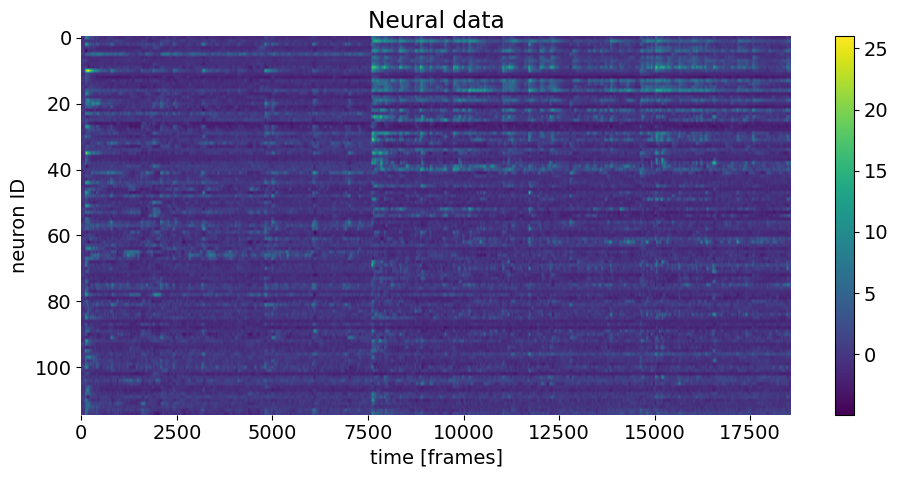

In [7]:
# Your code here:

# SOL:
plt.figure(figsize=(10, 5))
plt.imshow(neural_data, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Neural data')
plt.xlabel('time [frames]')
plt.ylabel('neuron ID')
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'pca neural_data.png'), dpi=300)
# SOL: Neuron firing of each neuron over time. Large numbers mean high activity, small numbers 
# mean low activity. Together with the attack vector (=behavioral action), the plotted neural data
# represents the neural response of the hypothalamus to different behavioral stimuli. And overall,
# the neurons do not respond in a synchronized manner, but rather in a distributed manner, with some
# neurons responding more than others, some responding simultaneously, and some responding at different
# times.

## 📝 Plot the attack vector: What do you see?

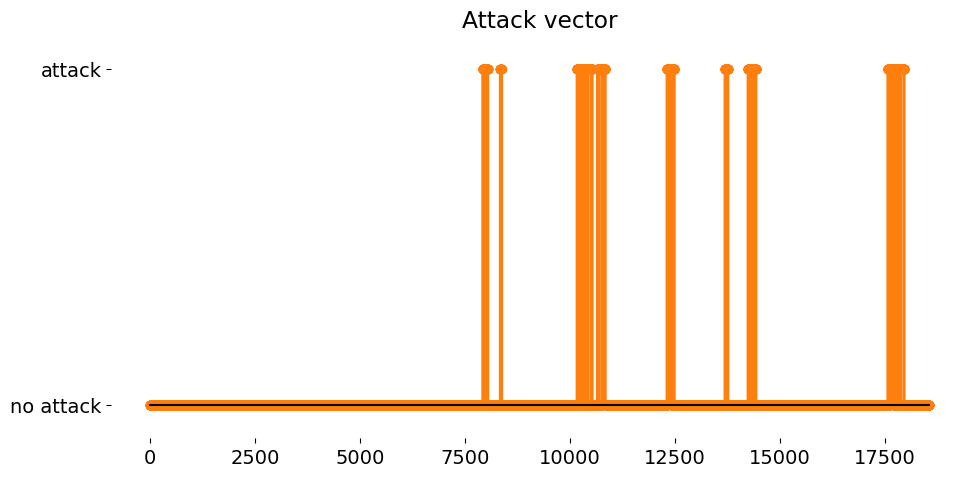

In [8]:
# Your code goes here:

# SOL:
plt.figure(figsize=(10, 5))
#plt.plot(attack_vector[0], '.', markersize=8)
plt.stem(attack_vector[0], linefmt='C1-', markerfmt='C1o', basefmt='k-')
plt.ylim([-0.1, 1.1])
# show only 0 and 1 tick, and rename it to no attack and attack:
plt.yticks([0, 1], ['no attack', 'attack'])
plt.title('Attack vector')
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'pca attack_vector.png'), dpi=300)
# SOL: Attack vector is a binary vector that indicates whether the animal is attacking (1) or not (0) 
# at each frame.

## 📝  Plot the gender vector: What do you see?

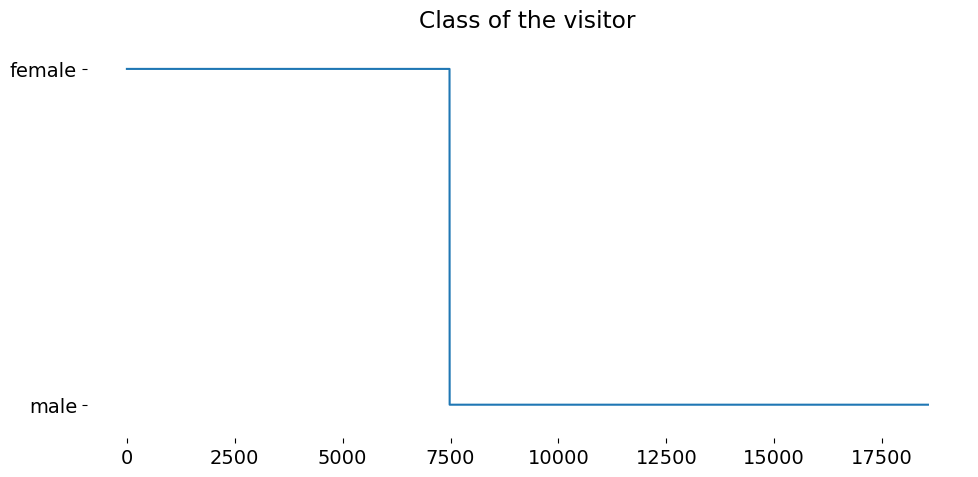

In [9]:
# Your code goes here:

# SOL:
plt.figure(figsize=(10, 5))
plt.plot(gender_vector[0], '-')
plt.ylim([-0.1, 1.1])
# show only 0 and 1 tick, and rename it to female and male:
plt.yticks([0, 1], ['male', 'female'])
plt.title("Class of the visitor")
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'pca gender_vector.png'), dpi=300)
# SOL: Gender vector contains the class of the visitor, either male (0) or female (1) at each frame.
# Together with the neural data and attack vector, we can investigate how the neural response of the
# hypothalamus differs between the exposure to male and female visitors. It seems, that the animal's
# hypothalamus response significantly changes when the visitor changes from female to male around
# frame 7500. This is interesting, as it suggests that the animal's hypothalamus responds differently
# to different social partners, i.e., the sex of that partner. 

## PCA principle
We now apply PCA to the neural data to reduce its dimensionality. We will apply PCA as follows: We treat each time step in the neural data as an $N$-dimensional data point, where $N$ is the number of neurons. We use PCA to reduce the dimensionality of the data points to S dimensions, with $S\lt N$. $S$ can be e.g. 3 or 10. We will then plot the data points in the $S$-dimensional space spanned by the principal components (PC).

## 📝 Estimate the number of principal components necessary
Before we perform PCA, we need to estimate how many principal components we should keep:

1. Create a PCA object (model) with 10 components
2. Fit the model to the neural data
3. Plot the explained variance ratio of the principal components (`your_model_fit.explained_variance_ratio_`). How much variance is explained by each of these principal components? What does this tell you about the data?

Explained variance ratio of the first 10 principal components: [0.35768848 0.13396795 0.07023927 0.04606784 0.03458948 0.02861416
 0.0259301  0.02388212 0.01757635 0.01528991]


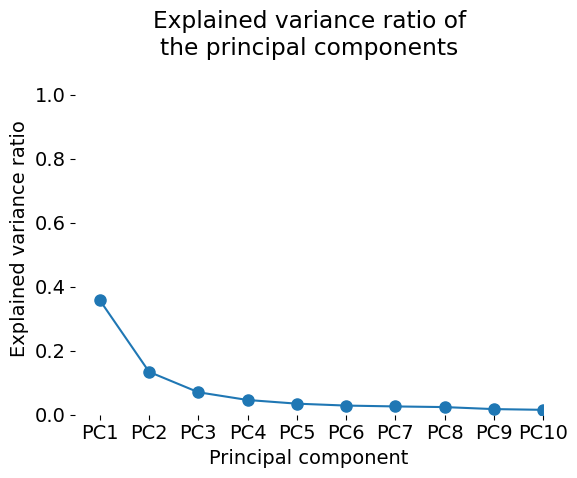

In [10]:
# Your code goes here:

# n_components  =
# PCA_model_S10 = 


# SOL:
n_components = 10
PCA_model_S10 = PCA(n_components=n_components)

# fit the PCA model to the neural data:

# SOL:
PCA_model_S10_fit = PCA_model_S10.fit_transform(neural_data.T)

# print the explained variance ratio of the principal components:

# SOL:
print(f"Explained variance ratio of the first {n_components} principal components: {PCA_model_S10.explained_variance_ratio_}")

# plot the explained variance ratio of the principal components:
# SOL:
plt.figure(figsize=(6.0, 5))
plt.plot(PCA_model_S10.explained_variance_ratio_, 'o-', markersize=8)
plt.ylim([0, 1.1])
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlim([-0.5, 2.5])
plt.xticks(range(n_components), [f'PC{i+1}' for i in range(n_components)])
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.title('Explained variance ratio of\nthe principal components')
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'pca explained_variance_ratio.png'), dpi=300)

# How much variance is explained by each of these principal components? What does this tell you about the data?

# SOL: [0.35768848 0.13396795 0.07023927, ...] tells us that the first principal component explains 35.77%
# of the variance in the data, the second principal component explains 13.40% of the variance, and the
# third principal component explains 7.02% of the variance in the data. This means that the first
# principal component captures the most variance in the data, and in total, the first three principal
# components capture 56.19% of the variance in the data. Any other PC beyond the first three captures
# less than 7% of the variance in the data. We therefore decide to keep the first three principal in the
# subsequent analysis.

## 📝 Perform the PCA
We now apply PCA and set $S=3$. We will then plot the data points in the 3D space spanned by the  first three principal components:

1. Create a PCA object (model) with 3 components.
2. Fit the model to the neural data.
3. What is the dimensionality of the PCAed neural data? What do these dimensions mean?
4. Plot the data points projected on the 3 principal components (PC) in the 3D space (`ax = plt.axes(projection='3d')`, `ax.plot3D()`). Also plot the 3 PC as 2D projections in a separate plot of 3 subplots.

Useful tip: With `ax.view_init(elev=30, azim=45)`, you can change the view of the 3D plot.

shape of the PCA of the neural data: (18561, 3)


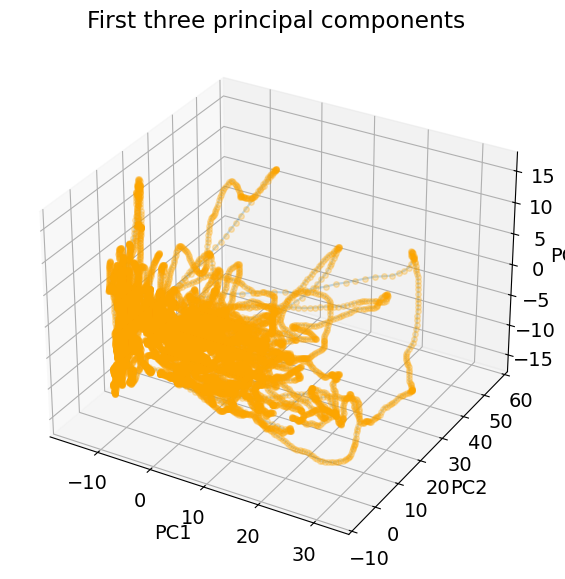

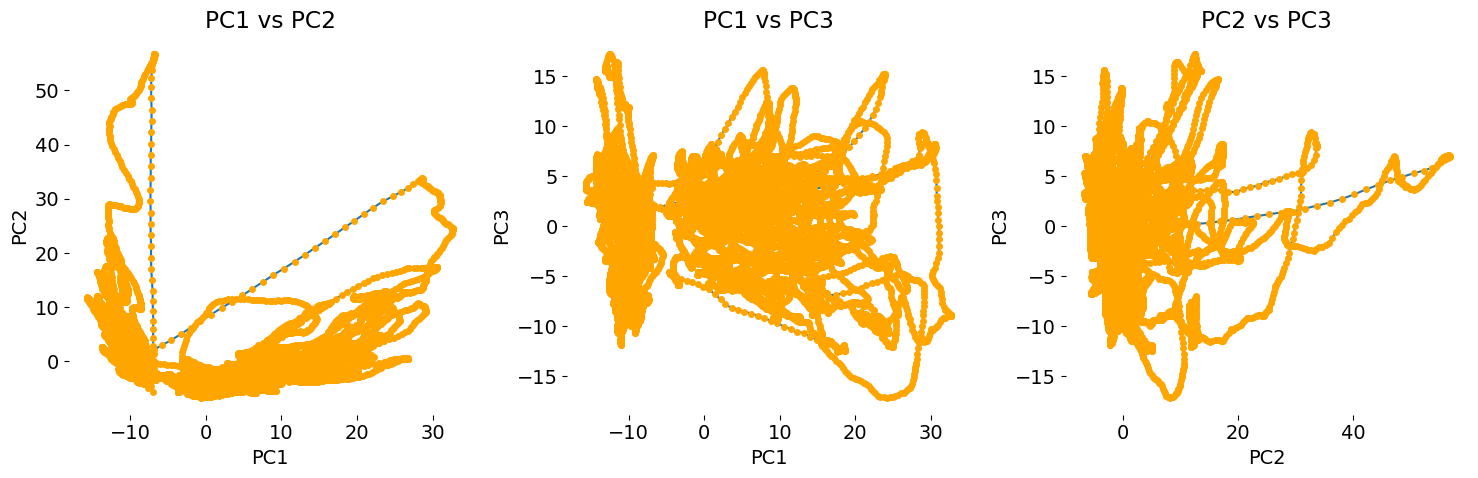

In [17]:
# Your code goes here:

# create a PCA object (model) with 3 components:
# n_components = 
# PCA_model_S3 = 

# SOL:
n_components = 3
PCA_model_S3 = PCA(n_components=n_components)

# fit the PCA model to the neural data:
# SOL:
PCA_model_S3_fit = PCA_model_S3.fit_transform(neural_data.T)

# What is the dimensionality of the PCAed neural data? What do these dimensions mean?

# SOL:
print(f"shape of the PCA of the neural data: {PCA_model_S3_fit.shape}")
# SOL: The first index is time, second index is the first 3 principal components (PCs).

# Plot the first three principal components in 3D space:
# SOL:
PC1 = PCA_model_S3_fit[:, 0]
PC2 = PCA_model_S3_fit[:, 1]
PC3 = PCA_model_S3_fit[:, 2]

fig = plt.figure(figsize=(7, 6))
ax = plt.axes(projection='3d')
ax.plot3D(PC1, PC2, PC3, 'o-', markersize=4, 
          markeredgecolor='orange', markerfacecolor='orange',
          alpha=0.25)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('First three principal components')
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'pca first_three_principal_components.png'), dpi=300)
plt.show()

# Plot the first three principal components in 2D space (3x):
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(PC1, PC2, 'o-', markersize=4, markeredgecolor='orange', markerfacecolor='orange')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PC1 vs PC2')

ax2.plot(PC1, PC3, 'o-', markersize=4, markeredgecolor='orange', markerfacecolor='orange')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC3')
ax2.set_title('PC1 vs PC3')

ax3.plot(PC2, PC3, 'o-', markersize=4, markeredgecolor='orange', markerfacecolor='orange')
ax3.set_xlabel('PC2')
ax3.set_ylabel('PC3')
ax3.set_title('PC2 vs PC3')

plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'pca first_three_principal_components_2D.png'), dpi=300)
plt.show()


# What interesting things do you notice about your dimensionality reduced data? Why are the axes 
# so different from each other? What do you think they represent?

# SOL: We don't definitively know what each PC represents and that's part of the difficulty. 
# Interpretability is a hard problem. Nevertheless, we can see, that there some kind of structure 
# in the data. In the following steps, we will try to understand the structure of the data better.


## 📝 Deciphering the structure of the data in the PCA space – factor: time
We will now try to understand the structure of the data in the PCA space by looking at the different parameters of the data. We start with the factor time:

1. Color-code the data points in the PCA space according to their occurrence in time (3D and 2D plots). What do you see?

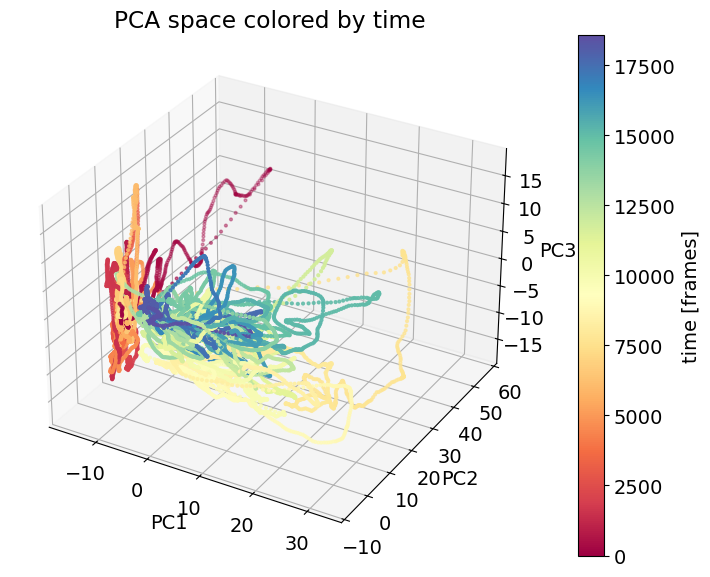

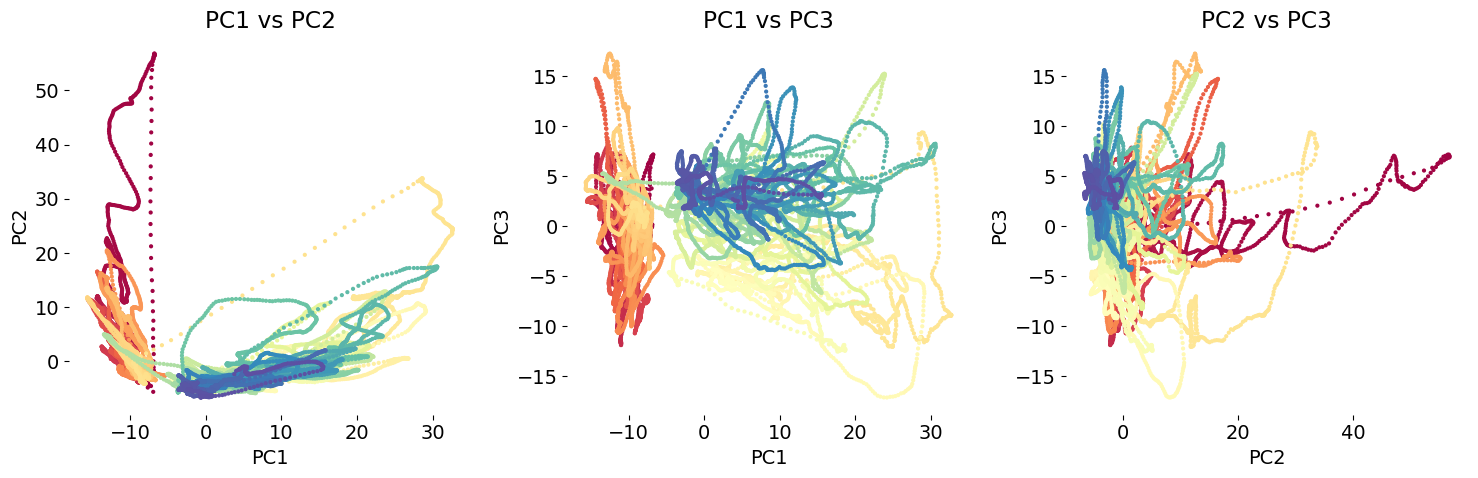

In [18]:
# Your code goes here:

# 3D plots:

# 2D plots:


# SOL:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
plot = ax.scatter(PC1, PC2, PC3, c=range(neural_data.shape[1]), cmap='Spectral', s=4)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA space colored by time')
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label('time [frames]')
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'pca colored_by_time.png'), dpi=300)
plt.show()

# 2D plots:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
plot1 = ax1.scatter(PC1, PC2, c=range(neural_data.shape[1]), cmap='Spectral', s=4)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PC1 vs PC2')

ax2.scatter(PC1, PC3, c=range(neural_data.shape[1]), cmap='Spectral', s=4)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC3')
ax2.set_title('PC1 vs PC3')

ax3.scatter(PC2, PC3, c=range(neural_data.shape[1]), cmap='Spectral', s=4)
ax3.set_xlabel('PC2')
ax3.set_ylabel('PC3')
ax3.set_title('PC2 vs PC3')


plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'pca colored_by_time_2D.png'), dpi=300)
plt.show()

# What do you see? What does this further tell you about the structure of the data in the PCA space?


## 📝 Deciphering the structure of the data in the PCA space – factor: behavior
Next, color-code the data points in the PCA space according to the attack vector. First, plot all  PCs, and then overplot the PC where `attack_vector` is 1. What do you see?

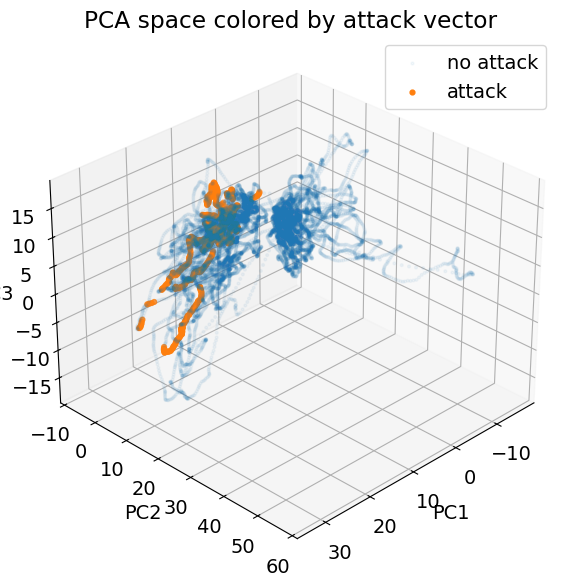

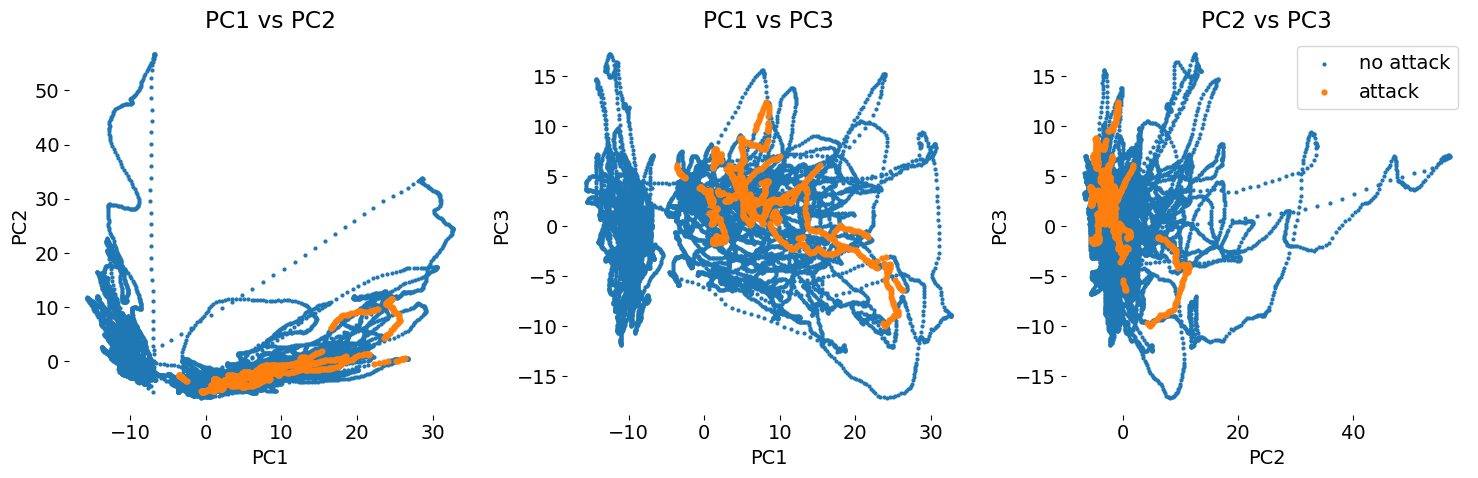

In [19]:
# Your code goes here:

# 3D plots:

# 2D plots:


# SOL:
PC1_noattack = PC1[attack_vector[0] == 0]
PC2_noattack = PC2[attack_vector[0] == 0]
PC3_noattack = PC3[attack_vector[0] == 0]

PC1_attack = PC1[attack_vector[0] == 1]
PC2_attack = PC2[attack_vector[0] == 1]
PC3_attack = PC3[attack_vector[0] == 1]

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.view_init(elev=30, azim=45)
ax.scatter(PC1_noattack, PC2_noattack, PC3_noattack,  s=4, alpha=0.05, zorder=-1, label='no attack')
ax.scatter(PC1_attack, PC2_attack, PC3_attack,  s=12, label='attack')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA space colored by attack vector')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'pca colored_by_attack_vector.png'), dpi=300)
plt.show()

# 2D plots:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(PC1_noattack, PC2_noattack,  s=4)
ax1.scatter(PC1_attack, PC2_attack,  s=12)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PC1 vs PC2')

ax2.scatter(PC1_noattack, PC3_noattack,  s=4)
ax2.scatter(PC1_attack, PC3_attack,  s=12)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC3')
ax2.set_title('PC1 vs PC3')

ax3.scatter(PC2_noattack, PC3_noattack,  s=4, label='no attack')
ax3.scatter(PC2_attack, PC3_attack,  s=12, label='attack')
ax3.set_xlabel('PC2')
ax3.set_ylabel('PC3')
ax3.set_title('PC2 vs PC3')
ax3.legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'pca colored_by_attack_vector_2D.png'), dpi=300)
plt.show()

# What do you see?

# SOL: The neuronal population activity seems to be different during attack and no attack. At
# least it is clearly separable in the PCA space. 

## 📝 Deciphering the structure of the data in the PCA space – factor: gender
Next, color-code the data points in the PCA space according the `gender_vector`. What do you see?

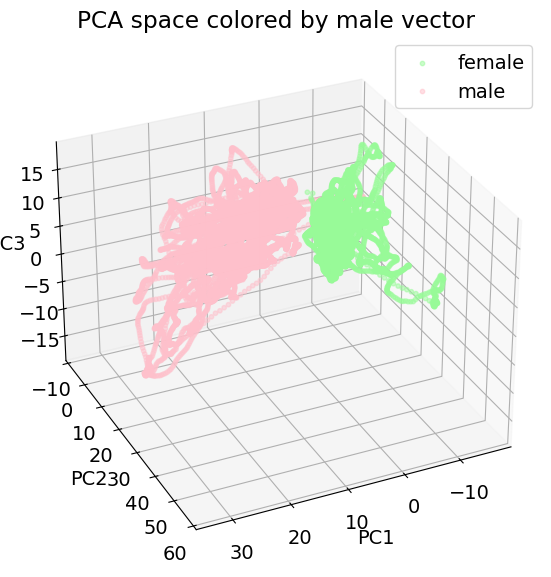

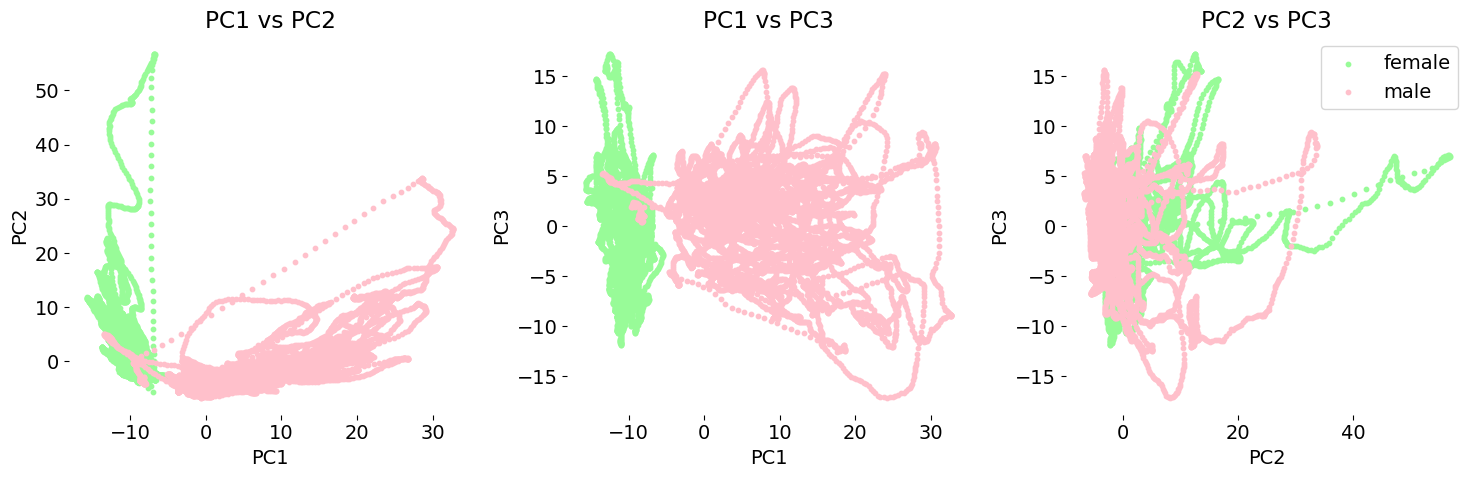

In [20]:
# Your code goes here:

# 3D plot:

# 2D plots:

# SOL
PC1_female = PC1[gender_vector[0] == 1]
PC2_female = PC2[gender_vector[0] == 1]
PC3_female = PC3[gender_vector[0] == 1]
    
PC1_male = PC1[gender_vector[0] == 0]
PC2_male = PC2[gender_vector[0] == 0]
PC3_male = PC3[gender_vector[0] == 0]

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection='3d')
ax.view_init(elev=30, azim=65)
ax.scatter(PC1_female, PC2_female, PC3_female,  s=10, alpha=0.5, label='female', c='palegreen')
ax.scatter(PC1_male, PC2_male, PC3_male,  s=10, alpha=0.5, label='male', c='pink')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA space colored by male vector')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'pca colored_by_gender_vector.png'), dpi=300)
plt.show()

# 2D plots:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(PC1_female, PC2_female,  s=10, c='palegreen')
ax1.scatter(PC1_male, PC2_male,  s=10, c='pink')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('PC1 vs PC2')

ax2.scatter(PC1_female, PC3_female,  s=10, c='palegreen')
ax2.scatter(PC1_male, PC3_male,  s=10, c='pink')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC3')
ax2.set_title('PC1 vs PC3')

ax3.scatter(PC2_female, PC3_female, s=10, c='palegreen', label="female")
ax3.scatter(PC2_male, PC3_male,  s=10, c='pink', label="male")
ax3.set_xlabel('PC2')
ax3.set_ylabel('PC3')
ax3.set_title('PC2 vs PC3')
ax3.legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULTSPATH, 'pca colored_by_gender_vector_2D.png'), dpi=300)
plt.show()

# What do you see?

# SOL: The response of the neuron population is clearly differentiated between the exposure
# to a male and female visitor.